In [1]:
import torch
import os
from tqdm.auto import tqdm
import sys
sys.path.insert(0,'../../code/data_utils/SampleClass/')
from Coordinates import Coordinates

In [6]:
data_folders = [
    (
        'tan',
        '/home/gridsan/gschuette/binz_group_shared/gkks/with_Zhuohan/tan_full_scan/full_scan/'
    ),
    (
        'generated',
        '/home/gridsan/gschuette/binz_group_shared/gkks/with_Zhuohan/produce_samples/GM/full_scan/corrected/'
    )
]

save_folder = './r_g_data/'
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

def parse_file(f):

    f1 = f.split('/')[-1].split('_')
    region_idx = int(f1[1])
    chrom = f1[-1].split('.')[0]

    if len(f1) == 6:
        cond_scale = f1[2]
        return chrom, cond_scale, region_idx
    else:
        return chrom, region_idx

def compute_rg(coords):
    return (coords.values - coords.values.mean(-2,keepdim=True)).square().sum(-1).mean(-1).sqrt()

def compute_sliding_rg(coords,window_size):

    r_gs = []
    i = 0
    j = window_size
    while j <= coords.num_beads:
        r_gs.append(compute_rg( coords[...,i:j,:] ))
        i+=1
        j+=1

    return torch.stack(r_gs,dim=-1)


window_sizes = list(range(2,65))
for label,folder in data_folders:

    r_g_dict = {
        'regions':[]
    }

    
    # Load all coordinates, concatenate them to accelerate computation
    start = 0
    coords = []
    files = os.listdir(folder)
    files.sort()
    for f in tqdm(files,desc=f'Loading {label} coordinates'):
        coords.append(Coordinates(folder+f))
        r_g_dict['regions'].append(
            (
                *parse_file(f),
                start,
                start + len(coords[-1])
            )
        )
        start = start + len(coords[-1])

    coords = coords[0].append(coords[1:])
    if torch.cuda.is_available():
        coords = coords.cuda()
    
    for ws in tqdm(window_sizes,desc=f'Computing {label} r_g values'):
        torch.save(
            {
                'regions':r_g_dict['regions'],
                'r_g':compute_sliding_rg(coords,ws).cpu()
            },
            save_folder + f'r_g_{label}_{ws}.pt'
        )
    



Loading tan coordinates:   0%|          | 0/2658 [00:00<?, ?it/s]

Computing tan r_g values:   0%|          | 0/63 [00:00<?, ?it/s]

Loading generated coordinates:   0%|          | 0/5316 [00:00<?, ?it/s]

Computing generated r_g values:   0%|          | 0/63 [00:00<?, ?it/s]

In [11]:
save_folder = './r_g_data/'
label='tan'
ws=63
a = torch.load(save_folder + f'r_g_{label}_{ws}.pt')

In [12]:
len(a['regions'])

2658

In [13]:
a['r_g'].shape

torch.Size([231520, 2])

In [2]:
coords = Coordinates('../../data/samples/origami_64_no_embed_reduction/eval_mode/corrected/unguided.pt')[:1000]

def compute_rg(coords):
    return (coords.values - coords.values.mean(-2,keepdim=True)).square().sum(-1).mean(-1).sqrt()

def compute_sliding_rg(coords,window_size):

    r_gs = []
    i = 0
    j = window_size
    while j <= coords.num_beads:
        r_gs.append(compute_rg( coords[...,i:j,:] ))
        i+=1
        j+=1

    return torch.stack(r_gs,dim=-1)

a = compute_sliding_rg(coords, 60)

a.shape

torch.Size([1000, 5])

In [18]:
a = torch.load('./r_g_data/r_g_generated_64.pt')

In [20]:
(a['r_g'] * 100).median()

tensor(406.7039)

In [21]:
a['r_g'][:1000,...].mean(0) * 100 

tensor([389.6393])

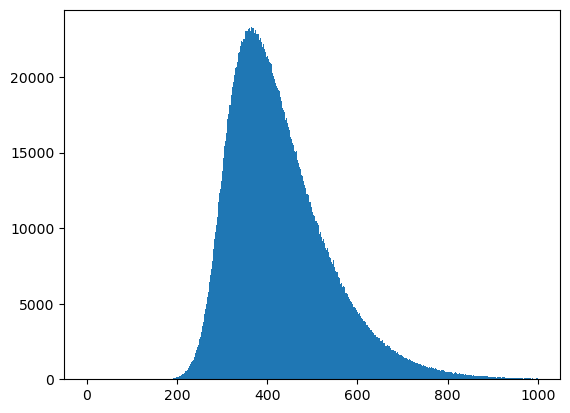

In [24]:
bins = torch.arange(1000).numpy()
plt.hist((a['r_g'] * 100).flatten().numpy(),bins=bins);